#Importar Librerías y definir funciones

In [307]:
#Importamos las Librerías:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PowerTransformer,QuantileTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline # generador de pipeline de trabajo
from sklearn.compose import ColumnTransformer #code to use feature cat and numeric together
from sklearn.compose import make_column_selector #selector in pipeline by dtypes

from scipy import stats
from sklearn.metrics import confusion_matrix,balanced_accuracy_score,recall_score,precision_score,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

!pip install git+https://github.com/scikit-optimize/scikit-optimize.git
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-rvzh_mia
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-rvzh_mia
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [189]:
#Determinamos cuántas columnas y rows queremos que nos muestre por defecto:

pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

In [190]:
#Función para pasar a minúsculas los string de una lista o array:

def to_lowercase(arr):
 new_arr = []
 for x in list(range(0,len(arr))):
   new = arr[x].lower()
   new_arr.append(new)
 return new_arr

In [191]:
#Funcion para extraer el primer digito de una lista o array

def getFirstDigit(num):
    while num >= 10:
        num = int(num/10)
    return num

In [192]:
def fill_nulls_df(df_with_nulls,df_groups,col_nulls):
   
  ''' Función para reemplazar los valores nulos de un dataframe, mediante los datos de un data frame (sin nulos) que determina los valores a utilizar de acuerdo a ciertas categorias
  df_with_nulls: Dataframe con los valores nulos
  df_groups: dataframe con los valores para reemplazar (debe tener una columna que concatene todos los valores de las categóricas llamada concat_cat)
  col_nulls: nombre de la columna del df_with_nulls que tiene nulos para reemplazar. '''

#seleccionar columnas categóricas para comparar en los dataframes
  cat_cols_comp = [] #lista donde se almacenan los nombres de las columnas
  for i in df_groups.select_dtypes('O').columns.values: #itera entre los nombres de cols del df con nulos
    if i in df_with_nulls.columns.values: #evalua si el nombre de la columna esta en el data frame con los datos para reemplazar
      cat_cols_comp.append(i) #agrega a la lista las columnas que estan en ambos dataframes
    else:
      'no hacer nada'
  
  #evaluar el valor de cada índice del dataframe con nulos para crear la lista de reemplazo
  list_reemplazo=[]
  median_var=np.median(df_with_nulls[col_nulls][df_with_nulls[col_nulls].isna()==False])
  for row in df_with_nulls.index.values:
    # seleccionar valor para reemplazar nulls
    if pd.isna(df_with_nulls[col_nulls][row]): #--> esto evalua si la row es nula
      #crea una lista con los valores de las categorias para esa row
      for_join=[] 
      for i in cat_cols_comp:
        for_join.append(str(df_with_nulls[i][row]))
      #crea una categoría concatenada para comparar con el concat del df que resume los datos
      concat = ''.join(for_join) 
      #devuelve el valor por el que hay que reemplazar el nulo
      new_value=df_groups[df_groups.concat_cat==concat][col_nulls].values[0] #devuelve el valor por el que hay que reemplazar el nulo
      #si encuentra valores nulos reemplaza por la mediana
      if math.isnan(new_value)==True:
         list_reemplazo.append(median_var)
      #si no es un valor nulo usa ese valor
      else:
         list_reemplazo.append(new_value)
    else:
      #devuelve el valor que hay que mantener porque la columna no es nula
      value_keep=df_with_nulls[col_nulls][row]
      list_reemplazo.append(value_keep)
  return list_reemplazo

#importar datos

In [193]:
#Importamos el dataset:

data = pd.read_csv("https://raw.githubusercontent.com/johanjohnson/DataCleaning---ChurnDataSet/main/churn_raw_data.csv")

df_orig =pd.DataFrame(data)

In [194]:
#Convertimos mayúsculas en minúsculas:

col_names = to_lowercase(df_orig.columns.values)

df_orig.set_axis(col_names,axis='columns',inplace=True)

df_orig.columns.values

array(['unnamed: 0', 'caseorder', 'customer_id', 'interaction', 'city',
       'state', 'county', 'zip', 'lat', 'lng', 'population', 'area',
       'timezone', 'job', 'children', 'age', 'education', 'employment',
       'income', 'marital', 'gender', 'churn', 'outage_sec_perweek',
       'email', 'contacts', 'yearly_equip_failure', 'techie', 'contract',
       'port_modem', 'tablet', 'internetservice', 'phone', 'multiple',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'paperlessbilling', 'paymentmethod', 'tenure', 'monthlycharge',
       'bandwidth_gb_year', 'item1', 'item2', 'item3', 'item4', 'item5',
       'item6', 'item7', 'item8'], dtype=object)

# Seleccionar columnas

Seleccionamos columnas en base a lo observado en el EDA. Seleccionamos las siguientes columnas:


**VARIABLE TARGET** 



> 'churn' Será la variable que se buscará predecir mediante el modelo.




**VARIABLES NUMÉRICAS SIGNIFICATIVAS:**


> En el EDA observamos correlación entre la variable target y estas variables:
'tenure', 'monthlycharge' y 'bandwith_gb_year'

>También se vió que las variables creadas a partir de las columnas de servicios tenían importancia cuando se analizaba el churn, estas variables son: 'q_online_serv','q_phone_serv','q_streaming','q_total_serv'

(Variables utilizadas para crear las variables de q_services: 'internetservice', 'onlinesecurity', 'onlinebackup', 'techsupport', 'deviceprotection', 'streamingtv', 'streamingmovies','phone')

> Variables que se relacionan con la calidad del servicio: 'outage_sec_perweek','email','contacts','yearly_equip_failure','contacts_by_month'

> Variables relacionadas a la encuesta, utilizaremos la variable 'total_encuesta' obtenida a partir de: 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8', ya que si bien no tiene una correlación con chur, consideramos que hace referencia a la percepción del cliente respecto del servicio.

**VARIABLES CATEGÓRICAS SIGNIFICATIVAS:**

> Variables relacionadas al tipo de contratación y servicios que tienen mayores diferencias en % de churn y no churn: 'internetservice', 'phone', 'multiple', 'onlinebackup', 'deviceprotection', 'streamingtv', 'streamingmovies', 'contract'

> Variables descriptivas de los clientes: 'Techie', 'Children', 'marital', 'gender', 'employement','zip_zone_cat'

In [195]:
#Creamos el Dataframe df únicamente con las columnas que nos interesan:

df = df_orig[[ 'zip', 'children', 'age', 'employment',
       'marital', 'gender', 'churn', 'outage_sec_perweek',
       'email', 'contacts', 'yearly_equip_failure', 'techie', 'contract',
       'internetservice', 'phone', 'multiple',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'tenure', 'monthlycharge','bandwidth_gb_year', 
       'item1', 'item2', 'item3', 'item4', 'item5',
       'item6', 'item7', 'item8']].copy(deep=True)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zip                   10000 non-null  int64  
 1   children              7505 non-null   float64
 2   age                   7525 non-null   float64
 3   employment            10000 non-null  object 
 4   marital               10000 non-null  object 
 5   gender                10000 non-null  object 
 6   churn                 10000 non-null  object 
 7   outage_sec_perweek    10000 non-null  float64
 8   email                 10000 non-null  int64  
 9   contacts              10000 non-null  int64  
 10  yearly_equip_failure  10000 non-null  int64  
 11  techie                7523 non-null   object 
 12  contract              10000 non-null  object 
 13  internetservice       10000 non-null  object 
 14  phone                 8974 non-null   object 
 15  multiple            

In [197]:
#Transformar children a categórica
df['children_cat'] = df['children'].apply(lambda x: 'other' if (math.isnan(x)==True) | (x >= 4)  else str(x))


In [198]:
#Creamos nuevas variables.

#Para servicios, cuenta cantidad de servicios contratados

df['q_online_serv'] = df.internetservice.apply(lambda x: 1 if x in ['Fiber Optic', 'DSL'] else 0).values + df.onlinesecurity.apply(lambda x: 1 if x == 'Yes' else 0).values + df.onlinebackup.apply(lambda x: 1 if x == 'Yes' else 0).values+df.techsupport.apply(lambda x: 1 if x== 'Yes' else 0).values
df['q_phone_serv']=df.phone.apply(lambda x: 1 if x == 'Yes' else 0).values+df.deviceprotection.apply(lambda x: 1 if x == 'Yes' else 0).values
df['q_streaming'] = df.streamingtv.apply(lambda x:1 if x=='Yes' else 0).values + df.streamingmovies.apply(lambda x:1 if x=='Yes'else 0).values

df['q_total_serv']= df['q_online_serv'].values+df['q_phone_serv'].values+df['q_streaming'].values

#Suma del valor obtenido por las categorías de la encueta
df['total_encuesta']=df.item1.values+df.item2.values+df.item3.values+df.item4.values+df.item5.values+df.item6.values+df.item7.values+df.item8.values

#Zip_first_number para sacar la info de la zona de eeuu:

df['zip_zone_cat'] = df.zip.apply(lambda x: getFirstDigit(x)).apply(lambda x: str(x))



In [199]:
#Cantidad de contactos por mes de antiguedad (contactos/antiguedad):

df['contacts_by_month'] = df.apply(lambda row: row['contacts']/row['tenure'] if math.isnan(row['tenure'])==False else row['contacts'],axis=1)

In [200]:
#Modificar las variables de q_service a categóricas (pruebo sin hacer esto)
#df.q_online_serv=df.q_online_serv.apply(lambda x: str(x))
#df.q_phone_serv=df.q_phone_serv.apply(lambda x: str(x))
#df.q_streaming=df.q_streaming.apply(lambda x: str(x))
#df.q_total_serv=df.q_total_serv.apply(lambda x: str(x))


In [201]:
#Para que la variable target este expresada en 0 y 1
encoder_target=LabelEncoder()

df['churn_transform']=encoder_target.fit_transform(df['churn'])

df[['churn','churn_transform']]


,churn,churn_transform
0,No,0
1,Yes,1
2,No,0
3,No,0
4,Yes,1
...,...,...
9995,No,0
9996,No,0
9997,No,0
9998,No,0


In [202]:
#Eliminamos las variables que no necesitamos:

df.drop([ 'churn', 'children','zip','onlinesecurity', 'age', 'techsupport', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7', 'item8'],axis=1,inplace=True)

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employment            10000 non-null  object 
 1   marital               10000 non-null  object 
 2   gender                10000 non-null  object 
 3   outage_sec_perweek    10000 non-null  float64
 4   email                 10000 non-null  int64  
 5   contacts              10000 non-null  int64  
 6   yearly_equip_failure  10000 non-null  int64  
 7   techie                7523 non-null   object 
 8   contract              10000 non-null  object 
 9   internetservice       10000 non-null  object 
 10  phone                 8974 non-null   object 
 11  multiple              10000 non-null  object 
 12  onlinebackup          10000 non-null  object 
 13  deviceprotection      10000 non-null  object 
 14  streamingtv           10000 non-null  object 
 15  streamingmovies     

# Crear Dataframe Test y Train

In [204]:
#primero spliteamos los datos para entrenar y el target
X = df.drop(columns='churn_transform')
y = df["churn_transform"]

In [205]:
#spliteo de train y test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

# Preparación del dataset de entrenamiento

##Transformaciones

### Llenado de nulos

In [206]:
#Verificamos los nulos de cada uno:
X_train.isna().sum()[X_train.isna().sum()>0]

techie               2016
phone                 817
tenure                738
bandwidth_gb_year     801
dtype: int64

In [207]:
# Armar dataFrames para rellenar nulos con las medianas para variables numéricas

#bandwidth_gb_year usamos la mediana agrupando por q_servicios_contratados y contract 
#(q_servicios no lo pueso poner ahora pq esta como int pero si lo hago como cat podría ponerlo)

medians_bandwidth=X_train[['contract','bandwidth_gb_year']].groupby(['contract']).median()
medians_bandwidth=medians_bandwidth.reset_index()
medians_bandwidth['concat_cat']=medians_bandwidth['contract']#+medians_bandwidth['q_total_serv']


In [208]:
def llenar_nulos(data):
  #variables categóricas reemplazo con unknown

  data['techie'].fillna('unknown',inplace=True)
  data['phone'].fillna('unknown',inplace=True)

  # Variables numéricas, depende la variable como llenamos los nulos:

  #Tenure con 0, porque mediante el análisis univariado se determinó que los tenures nulos son de personas que aún no tienen meses de antiguedad en la empresa, es decir su antiguedad es 0

  data['tenure'].fillna(0,inplace=True)

  #bandwidth_gb_year

  data['bandwidth_gb_year']=fill_nulls_df(data,medians_bandwidth,'bandwidth_gb_year')
  return

In [209]:
llenar_nulos(X_train)

In [210]:
#Verificamos los nulos de cada uno:
X_train.isna().sum()[X_train.isna().sum()>0]

Series([], dtype: int64)

### Separo variables cat y numéricas para transformaciones

In [211]:
#Selecciono las variabes categóricas
cat_columns=X_train.select_dtypes(exclude='number').columns
cat_columns

Index(['employment', 'marital', 'gender', 'techie', 'contract',
       'internetservice', 'phone', 'multiple', 'onlinebackup',
       'deviceprotection', 'streamingtv', 'streamingmovies', 'children_cat',
       'zip_zone_cat'],
      dtype='object')

In [212]:
#selecciono las variables numéricas float
num_columns=X_train.select_dtypes(include='float64').columns
num_columns

Index(['outage_sec_perweek', 'tenure', 'monthlycharge', 'bandwidth_gb_year',
       'contacts_by_month'],
      dtype='object')

In [213]:
#seleccion de columnas normalizadas
normal_cols = []

#loop en todas las columnas del x_train
for col in num_columns:

  #calculo de D'Agostino's K-squared test
  k2, p_value = stats.normaltest(X_train[col])
  #chequeo de si p-value es mayor a 0.05
  if p_value > 0.05:
    normal_cols.append(col)
  
  #print de todas las variables con su valor
  print(f"columna {col} -----Estadístico = {k2}, p-value = {round(p_value,2)}")

#seleccion de las variables que no estan en normal,  nos daran el resto de columnas no seleccionadas
not_stander = list(set(num_columns) - set(normal_cols))


columna outage_sec_perweek -----Estadístico = 4954.693582306467, p-value = 0.0
columna tenure -----Estadístico = 34595.76952651616, p-value = 0.0
columna monthlycharge -----Estadístico = 283.7793247796785, p-value = 0.0
columna bandwidth_gb_year -----Estadístico = 42549.042862898816, p-value = 0.0
columna contacts_by_month -----Estadístico = 6968.883227392298, p-value = 0.0


In [214]:
not_stander

['monthlycharge',
 'outage_sec_perweek',
 'contacts_by_month',
 'bandwidth_gb_year',
 'tenure']

In [215]:
normal_cols

[]

### Pipeline transformaciones

In [216]:
cat_transform = Pipeline([('OneHot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary') )])

num_transform = Pipeline([('Robust',RobustScaler())])



In [217]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transform, not_stander),
        ("cat", cat_transform, cat_columns),
    ]
)

In [218]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('Robust', RobustScaler())]),
                                 ['monthlycharge', 'outage_sec_perweek',
                                  'contacts_by_month', 'bandwidth_gb_year',
                                  'tenure']),
                                ('cat',
                                 Pipeline(steps=[('OneHot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['employment', 'marital', 'gender', 'techie', 'contract',
       'internetservice', 'phone', 'multiple', 'onlinebackup',
       'deviceprotection', 'streamingtv', 'streamingmovies', 'children_cat',
       'zip_zone_cat'],
      dtype='object'))])

In [219]:
#trasnformacion de X_train 
X_array_enc = preprocessor.transform(X_train)
#genero nombres de columnas
new_num_col = preprocessor.named_transformers_['num']['Robust'].get_feature_names_out(not_stander)
new_cat_col = preprocessor.named_transformers_['cat']['OneHot'].get_feature_names_out(cat_columns)

columns_enc = np.append(new_num_col,new_cat_col)

#armar el datafram de las transformaciones
X_train_enc = pd.DataFrame(X_array_enc, columns = columns_enc, index = X_train.index)

#drop de columnas que se transformaron
X_train.drop(columns=np.append(not_stander,cat_columns),inplace=True)

#join de las nuevas columnas
X_train = X_train.join(X_train_enc)

In [220]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 8055 to 4477
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   email                        8000 non-null   int64  
 1   contacts                     8000 non-null   int64  
 2   yearly_equip_failure         8000 non-null   int64  
 3   q_online_serv                8000 non-null   int64  
 4   q_phone_serv                 8000 non-null   int64  
 5   q_streaming                  8000 non-null   int64  
 6   q_total_serv                 8000 non-null   int64  
 7   total_encuesta               8000 non-null   int64  
 8   monthlycharge                8000 non-null   float64
 9   outage_sec_perweek           8000 non-null   float64
 10  contacts_by_month            8000 non-null   float64
 11  bandwidth_gb_year            8000 non-null   float64
 12  tenure                       8000 non-null   float64
 13  employment_Full

### Variables Numéricas Correlacionadas

In [221]:
corr_table = X_train.corr('spearman')
corr_table = corr_table[((corr_table>=0.5)|(corr_table<=-0.5)) & (corr_table!=1.00000)]
corr_table = corr_table.dropna(how='all').dropna(how='all',axis=1)
corr_cols = corr_table.columns[2:]
corr_vars = corr_table.unstack().dropna().drop_duplicates().reset_index()
corr_vars

,level_0,level_1,0
0,contacts,contacts_by_month,0.830942
1,q_online_serv,q_total_serv,0.695815
2,q_online_serv,onlinebackup_Yes,0.534598
3,q_phone_serv,phone_Yes,0.563529
4,q_phone_serv,deviceprotection_Yes,0.811860
5,q_streaming,q_total_serv,0.529243
6,q_streaming,monthlycharge,0.757086
7,q_streaming,streamingtv_Yes,0.701498
8,q_streaming,streamingmovies_Yes,0.701199
9,q_total_serv,monthlycharge,0.686184


In [222]:
X_train_lr_v1=X_train.drop(columns=['contacts','bandwidth_gb_year']).copy(deep=True)  #elimino variables que estan altamente correlacionadas con otras

X_train_lr_v2=X_train.drop(columns=['contacts','bandwidth_gb_year','q_streaming','q_total_serv','streamingmovies_Yes','onlinebackup_Yes', 'phone_Yes', 'deviceprotection_Yes',
                                    'streamingtv_Yes', 'gender_Male', 'techie_unknown','contract_Two Year','internetservice_Fiber Optic']).copy(deep=True)  #elimino variables que estan altamente correlacionadas con otras

In [223]:
X_train_lr_v1.columns

Index(['email', 'yearly_equip_failure', 'q_online_serv', 'q_phone_serv',
       'q_streaming', 'q_total_serv', 'total_encuesta', 'monthlycharge',
       'outage_sec_perweek', 'contacts_by_month', 'tenure',
       'employment_Full Time', 'employment_Part Time', 'employment_Retired',
       'employment_Student', 'employment_Unemployed', 'marital_Divorced',
       'marital_Married', 'marital_Never Married', 'marital_Separated',
       'marital_Widowed', 'gender_Female', 'gender_Male',
       'gender_Prefer not to answer', 'techie_No', 'techie_Yes',
       'techie_unknown', 'contract_Month-to-month', 'contract_One year',
       'contract_Two Year', 'internetservice_DSL',
       'internetservice_Fiber Optic', 'internetservice_None', 'phone_No',
       'phone_Yes', 'phone_unknown', 'multiple_Yes', 'onlinebackup_Yes',
       'deviceprotection_Yes', 'streamingtv_Yes', 'streamingmovies_Yes',
       'children_cat_0.0', 'children_cat_1.0', 'children_cat_2.0',
       'children_cat_3.0', 'children_

In [224]:
corr_check = X_train_lr_v2.corr('spearman')
corr_check = corr_check[((corr_check>=0.5)|(corr_check<=-0.5)) & (corr_check!=1.00000)]
corr_check = corr_check.dropna(how='all').dropna(how='all',axis=1)
corr_cols = corr_check.columns[2:]
corr_vars_check = corr_check.unstack().dropna().drop_duplicates().reset_index()
corr_vars_check

,level_0,level_1,0
0,contract_Month-to-month,contract_One year,-0.565767


### PCA -Probar reducir dimensionalidad

In [225]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

pca.explained_variance_ratio_

array([0.34184942, 0.22215074, 0.16441333])

#Training del modelo

## Decision tree

### Decision tree base

In [226]:
#decision tree base

tree_base = tree.DecisionTreeClassifier(random_state = 42)

tree_base.fit(X_train, y_train) #variables num transformadas

tree_base_pca = tree.DecisionTreeClassifier(random_state = 42)

tree_base_pca.fit(X_train_pca, y_train) #pca para reducir dimensionalidad


DecisionTreeClassifier(random_state=42)

### Desicion tree con búsqueda de parámetros

In [227]:
model_tree = tree.DecisionTreeClassifier(random_state = 42)

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'] + list(np.arange(0.20,1.00,0.10)),
    'max_depth' : list(range(0,11,1))+[None],
    'criterion' :['gini', 'entropy','log_loss'],
    'min_samples_split': [2,5,8,11],
    'min_samples_leaf': [2,5,8,11]     
}

In [228]:
tree_CV = RandomizedSearchCV(model_tree,
                               param_distributions=param_grid,
                               n_iter = 100,
                               scoring = 'f1',
                               n_jobs = -1,
                               cv = 3,
                               random_state = 100,
                               return_train_score= True)

In [229]:
tree_CV.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         0.2,
                                                         0.30000000000000004,
                                                         0.4000000000000001,
                                                         0.5000000000000001,
                                                         0.6000000000000001,
                                                         0.7000000000000002,
                                                         0.80000

In [230]:
pd.DataFrame(tree_CV.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
78,0.081400,0.026629,0.006993,0.000097,8,11,0.9,5,gini,"{'min_samples_split': 8, 'min_samples_leaf': 1...",0.773973,0.763285,0.771930,0.769729,0.004632,1,0.778046,0.785195,0.782398,0.781880,0.002942
35,0.089387,0.021455,0.015191,0.001597,8,2,0.8,7,gini,"{'min_samples_split': 8, 'min_samples_leaf': 2...",0.759184,0.771429,0.763954,0.764856,0.005039,2,0.800686,0.809946,0.811383,0.807338,0.004740
2,0.048814,0.001607,0.007164,0.000197,11,5,0.8,7,gini,"{'min_samples_split': 11, 'min_samples_leaf': ...",0.765784,0.760137,0.767270,0.764397,0.003073,3,0.798623,0.807101,0.805832,0.803852,0.003734
10,0.087866,0.022594,0.012856,0.004026,5,11,0.9,7,gini,"{'min_samples_split': 5, 'min_samples_leaf': 1...",0.783562,0.755003,0.750769,0.763111,0.014563,4,0.801946,0.800276,0.786687,0.796303,0.006834
46,0.061785,0.019965,0.015713,0.006554,5,8,0.4,7,gini,"{'min_samples_split': 5, 'min_samples_leaf': 8...",0.772006,0.770061,0.743536,0.761867,0.012987,5,0.779797,0.789545,0.778477,0.782606,0.004936


In [231]:
tree_CV.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features=0.9000000000000001,
                       min_samples_leaf=11, min_samples_split=8,
                       random_state=42)

## Random Forest

### Random forest base

In [232]:
rfc_base=RandomForestClassifier(random_state=42)

rfc_base.fit(X_train, y_train)

rfc_base_pca = RandomForestClassifier(random_state=42)

rfc_base_pca.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

### Random Forest con búsqueda de parámetros

In [233]:
#seleccipon del clasificador
rfc=RandomForestClassifier(random_state=42)

#conjunto de parametros

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'] + list(np.arange(0.20,1.00,0.10)),
    'max_depth' : list(range(0,11,1))+[None],
    'criterion' :['gini', 'entropy','log_loss'],
    'min_samples_split': [2,5,8,11],
    'min_samples_leaf': [2,5,8,11]     
}

#seleccion del calsificador general
CV_rfc = RandomizedSearchCV(rfc,
                               param_distributions=param_grid,
                               n_iter = 100,
                               scoring = 'f1',
                               n_jobs = -1,
                               cv = 3,
                               random_state = 100,
                               return_train_score= True)

#entrenamiento 
CV_rfc.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         0.2,
                                                         0.30000000000000004,
                                                         0.4000000000000001,
                                                         0.5000000000000001,
                                                         0.6000000000000001,
                                                         0.7000000000000002,
                                                         0.80000

In [234]:
#dataframe con toda la infor de cada corrida de entrenamiento
results = pd.DataFrame(CV_rfc.cv_results_)

#info del mejor modelo
CV_rfc.best_estimator_

RandomForestClassifier(criterion='entropy', max_features=0.5000000000000001,
                       min_samples_leaf=8, random_state=42)

In [235]:
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
33,2.955919,0.027749,0.066410,0.002730,2,8,0.5,None,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 8...",0.788227,0.781409,0.779164,0.782933,0.003854,1,0.872333,0.872317,0.869061,0.871237,0.001539
44,3.702886,0.045088,0.062739,0.004303,2,8,0.7,9,entropy,"{'min_samples_split': 2, 'min_samples_leaf': 8...",0.796574,0.776824,0.775330,0.782909,0.009681,2,0.839827,0.838319,0.845302,0.841149,0.003000
95,2.285772,0.028901,0.060344,0.000578,2,5,0.6,7,gini,"{'min_samples_split': 2, 'min_samples_leaf': 5...",0.794637,0.771429,0.778825,0.781630,0.009680,3,0.820440,0.820495,0.829562,0.823499,0.004287
87,3.099316,0.046702,0.065858,0.009908,8,11,0.6,8,entropy,"{'min_samples_split': 8, 'min_samples_leaf': 1...",0.795129,0.778255,0.770909,0.781431,0.010140,4,0.822812,0.819730,0.831493,0.824678,0.004980
49,1.961076,0.030232,0.063092,0.001512,5,5,0.3,9,entropy,"{'min_samples_split': 5, 'min_samples_leaf': 5...",0.795683,0.775540,0.772495,0.781239,0.010289,5,0.847482,0.846154,0.851613,0.848416,0.002324


## Logistic Regression

In [236]:
#Entreno con los datos del primer data set que arme para logistic reg
clf_v1 = LogisticRegression(C=1, n_jobs=-1, random_state=34)
clf_v1.fit(X_train_lr_v1, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=34)

In [237]:
#Entreno con los datos del primer data set que arme para logistic reg
clf_v2 = LogisticRegression(C=1, n_jobs=-1, random_state=34)
clf_v2.fit(X_train_lr_v2, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=34)

In [238]:
#Entreno con los datos del primer data set que arme para logistic reg
clf_pca = LogisticRegression(C=1, n_jobs=-1, random_state=34)
clf_pca.fit(X_train_pca, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=34)

## KNN

In [283]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

###KNN con busqueda de parametros

In [289]:
#seleccipon del clasificador
knn_cv= KNeighborsClassifier()

#conjunto de parametros

param_grid = { 
    'n_neighbors': [1,2,3,4,5,6,7],
    'weights' : ['uniform', 'distance'],
    'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [1,5,10,20,30,40]    
}

#seleccion del calsificador general
CV_knn = RandomizedSearchCV(knn_cv,
                               param_distributions=param_grid,
                               n_iter = 100,
                               scoring = 'f1',
                               n_jobs = -1,
                               cv = 3,
                               random_state = 100,
                               return_train_score= True)

#entrenamiento 
CV_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [1, 5, 10, 20, 30, 40],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7],
                                        'weights': ['uniform', 'distance']},
                   random_state=100, return_train_score=True, scoring='f1')

#Transformaciones test

##Llenado de nulos

In [239]:
#check nulos
X_test.isna().sum()[X_test.isna().sum()>0]

techie               461
phone                209
tenure               193
bandwidth_gb_year    220
dtype: int64

In [240]:
llenar_nulos(X_test)

In [241]:
#check nulos
X_test.isna().sum()[X_test.isna().sum()>0]

Series([], dtype: int64)

## Pipeline variables categóricas y numéricas float

In [242]:
#trasnformacion de X_test 
X_test_transform = preprocessor.transform(X_test)

#armar el datafram de las transformaciones
X_test_enc = pd.DataFrame(X_test_transform, columns = columns_enc, index = X_test.index)

#drop de columnas que se transformaron
X_test.drop(columns=np.append(not_stander,cat_columns),inplace=True)

#join de las nuevas columnas
X_test = X_test.join(X_test_enc)

In [243]:
X_test

,email,contacts,yearly_equip_failure,q_online_serv,q_phone_serv,q_streaming,q_total_serv,total_encuesta,monthlycharge,outage_sec_perweek,contacts_by_month,bandwidth_gb_year,tenure,employment_Full Time,employment_Part Time,employment_Retired,employment_Student,employment_Unemployed,marital_Divorced,marital_Married,marital_Never Married,marital_Separated,marital_Widowed,gender_Female,gender_Male,gender_Prefer not to answer,techie_No,techie_Yes,techie_unknown,contract_Month-to-month,contract_One year,contract_Two Year,internetservice_DSL,internetservice_Fiber Optic,internetservice_None,phone_No,phone_Yes,phone_unknown,multiple_Yes,onlinebackup_Yes,deviceprotection_Yes,streamingtv_Yes,streamingmovies_Yes,children_cat_0.0,children_cat_1.0,children_cat_2.0,children_cat_3.0,children_cat_other,zip_zone_cat_1,zip_zone_cat_2,zip_zone_cat_3,zip_zone_cat_4,zip_zone_cat_5,zip_zone_cat_6,zip_zone_cat_7,zip_zone_cat_8,zip_zone_cat_9
8158,10,0,1,2,2,2,6,31,0.656683,-0.460533,-0.150178,0.730629,-0.315826,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3484,17,0,0,2,2,1,5,27,0.538100,-1.380294,-0.150178,-0.159351,0.190317,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5443,8,1,0,2,1,0,3,31,-1.040623,-0.814521,-0.041738,0.747840,0.989467,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7278,9,0,3,2,2,0,4,32,-0.989955,0.340706,-0.150178,0.581480,0.925371,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8278,16,0,1,3,2,1,6,23,0.104860,-0.340988,-0.150178,0.578647,0.777308,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759,6,0,0,2,2,0,4,32,-0.699073,-2.015835,-0.150178,-0.590837,-0.269149,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7659,10,0,0,1,1,0,2,28,-0.200880,-1.430828,-0.150178,0.000000,0.400566,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8081,11,2,2,2,1,2,5,32,0.645075,0.182968,0.074458,0.752676,0.944390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3072,13,0,0,1,1,0,2,23,-0.381180,-0.732895,-0.150178,-0.558184,-0.109240,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##Variables numéricas correlacionadas

In [244]:
X_test_lr_v1=X_test.drop(columns=['contacts','bandwidth_gb_year']).copy(deep=True) #elimino variables que estan altamente correlacionadas con otras

X_test_lr_v2=X_test.drop(columns=['contacts','bandwidth_gb_year','q_streaming','q_total_serv','streamingmovies_Yes','onlinebackup_Yes', 'phone_Yes', 'deviceprotection_Yes',
                                    'streamingtv_Yes', 'gender_Male', 'techie_unknown','contract_Two Year','internetservice_Fiber Optic']).copy(deep=True)  #elimino variables que estan altamente correlacionadas con otras

## PCA

In [245]:
X_test_pca=pca.transform(X_test)

#Predicciones

## Decision tree común

### Decision tree base 

In [246]:
#decision tree base

pred_tree_base = tree_base.predict(X_test)


pred_tree_pca = tree_base_pca.predict(X_test_pca) #pca para reducir dimensionalidad



In [261]:
results ={}

In [262]:
results['tree_base']= {'algoritmo': 'Decision Tree con X_train',
                       'f-score-train': f1_score(y_train, tree_base.predict(X_train)),
                       'f-score-test': f1_score(y_test,pred_tree_base),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_tree_base),
                       'precision': precision_score(y_test, pred_tree_base),
                       'recall': recall_score(y_test, pred_tree_base),
                       'auc': roc_auc_score(y_test, pred_tree_base),
                       'params': tree_base.get_params()}

results['pred_tree_pca']= {'algoritmo': 'Decision Tree con PCA',
                       'f-score-train': f1_score(y_train, tree_base_pca.predict(X_train_pca)),
                       'f-score-test': f1_score(y_test,pred_tree_pca),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_tree_pca),
                       'precision': precision_score(y_test, pred_tree_pca),
                       'recall': recall_score(y_test, pred_tree_pca),
                       'auc': roc_auc_score(y_test, pred_tree_pca),
                       'params': tree_base_pca.get_params()}

In [249]:
#Accuracy
print('Accuracy score for test data is:', balanced_accuracy_score(y_test,pred_tree_base))

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, pred_tree_base))

confusion_matrix.index = ['Actual Churn','Actual No Churn']
confusion_matrix.columns = ['Predicted Churn','Predicted No Churn']
print(confusion_matrix)

Accuracy score for test data is: 0.8083814657938647
                 Predicted Churn  Predicted No Churn
Actual Churn                1331                 139
Actual No Churn              153                 377


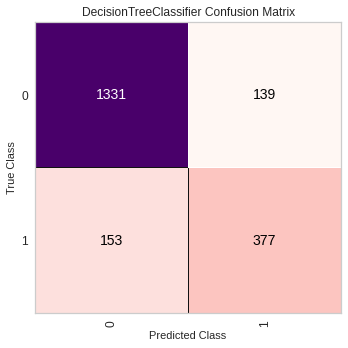

In [250]:
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
cm = ConfusionMatrix(tree_base, classes=[0, 1], cmap='RdPu')
cm.score(X_test, y_test)
for label in cm.ax.texts:
    label.set_size(14)
cm.poof()

In [251]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, pred_tree_base))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1470
           1       0.73      0.71      0.72       530

    accuracy                           0.85      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.85      0.85      0.85      2000



### Con CV y búsqueda de hiperparámetros

In [252]:
pred_tree_cv = tree_CV.predict(X_test)

In [263]:
results['tree_CV']= {'algoritmo': 'Decision Tree con búsqueda de parámetros',
                       'f-score-train': f1_score(y_train, tree_CV.predict(X_train)),
                       'f-score-test': f1_score(y_test,pred_tree_cv),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_tree_cv),
                       'precision': precision_score(y_test, pred_tree_cv),
                       'recall': recall_score(y_test, pred_tree_cv),
                       'auc': roc_auc_score(y_test, pred_tree_cv),
                       'params': tree_CV.best_estimator_.get_params()}


In [255]:
impo = pd.DataFrame(list(zip(X_test.columns, tree_CV.best_estimator_.feature_importances_)), columns=['feature', 'importance'])
impo.sort_values('importance', ascending=False).head(10)

,feature,importance
11,bandwidth_gb_year,0.341086
5,q_streaming,0.331371
29,contract_Month-to-month,0.183949
12,tenure,0.105817
32,internetservice_DSL,0.012713
38,multiple_Yes,0.010149
8,monthlycharge,0.007349
10,contacts_by_month,0.005217
9,outage_sec_perweek,0.001042
33,internetservice_Fiber Optic,0.000911


Text(0, -0.3, 'Churn con Decision Tree\n\n  f-score-test = 0.7691 \n  f-score-train = 0.779 ')

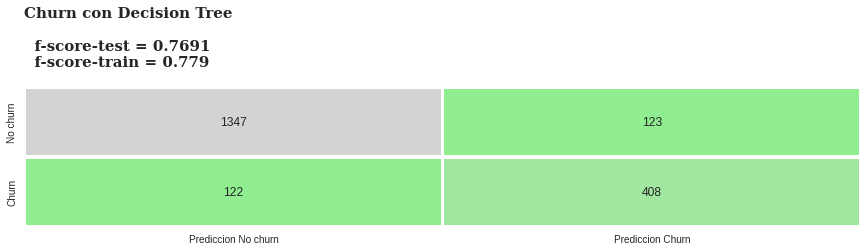

In [333]:
cm=confusion_matrix(y_test, pred_tree_cv)
text = '''Churn con Decision Tree

  f-score-test = {} 
  f-score-train = {} '''.format(round(f1_score(y_test,pred_tree_cv),4),round(f1_score(y_train, tree_CV.predict(X_train)),4))

background_color = 'white' 
colormap = LinearSegmentedColormap.from_list("", ["lightgreen","lightgray"])


fig = plt.figure(figsize=(15,18)) 
fig.patch.set_facecolor(background_color) 
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

#grafico de la matriz de confusion 
sns.heatmap(cm, linewidths=2.5,yticklabels=['No churn','Churn'],
            xticklabels=['Prediccion No churn','Prediccion Churn'], 
            cmap=colormap, 
            cbar=None,
            annot=True,
            fmt='d',
            ax=ax0,
            annot_kws={"fontsize":12}
            )


ax0.text(0, -0.3, text,fontsize=15, fontweight='bold', fontfamily='serif')

## Random Forest

### Random Forest base

In [256]:
pred_rfc_base = rfc_base.predict(X_test)

pred_rfc_pca = rfc_base_pca.predict(X_test_pca)

In [264]:
results['rfc_base']= {'algoritmo': 'Random Forest con X_train',
                       'f-score-train': f1_score(y_train, rfc_base.predict(X_train)),
                       'f-score-test': f1_score(y_test,pred_rfc_base),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_rfc_base),
                       'precision': precision_score(y_test, pred_rfc_base),
                       'recall': recall_score(y_test, pred_rfc_base),
                      'auc': roc_auc_score(y_test, pred_rfc_base),
                       'params': rfc_base.get_params()}

results['rfc_pca']= {'algoritmo': 'Random forest con PCA',
                       'f-score-train': f1_score(y_train, rfc_base_pca.predict(X_train_pca)),
                       'f-score-test': f1_score(y_test,pred_rfc_pca),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_rfc_pca),
                       'precision': precision_score(y_test, pred_rfc_pca),
                       'recall': recall_score(y_test, pred_rfc_pca),
                     'auc': roc_auc_score(y_test, pred_rfc_pca),
                       'params': rfc_base_pca.get_params()}

### Random forest con CV y búsqueda de parámetros

In [258]:
#prediccion
pred_rf = CV_rfc.predict(X_test)

In [265]:
results['rfc_CV']= {'algoritmo': 'Random Forest con búsqueda de parámetros',
                       'f-score-train': f1_score(y_train, CV_rfc.predict(X_train)),
                       'f-score-test': f1_score(y_test,pred_rf),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_rf),
                       'precision': precision_score(y_test, pred_rf),
                       'recall': recall_score(y_test, pred_rf),
                        'auc': roc_auc_score(y_test, pred_rf),
                       'params': CV_rfc.best_estimator_.get_params()}

Text(0, -0.3, 'Churn con Random Forest\n\n  f-score-test = 0.8027 \n  f-score-train = 0.8732 ')

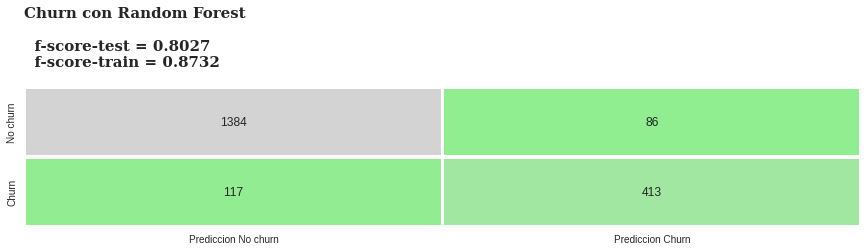

In [325]:
cm=confusion_matrix(y_test, pred_rf)
text = '''Churn con Random Forest

  f-score-test = {} 
  f-score-train = {} '''.format(round(f1_score(y_test,pred_rf),4),round(f1_score(y_train, CV_rfc.predict(X_train)),4))

background_color = 'white' 
colormap = LinearSegmentedColormap.from_list("", ["lightgreen","lightgray"])


fig = plt.figure(figsize=(15,18)) 
fig.patch.set_facecolor(background_color) 
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

#grafico de la matriz de confusion 
sns.heatmap(cm, linewidths=2.5,yticklabels=['No churn','Churn'],
            xticklabels=['Prediccion No churn','Prediccion Churn'], 
            cmap=colormap, 
            cbar=None,
            annot=True,
            fmt='d',
            ax=ax0,
            annot_kws={"fontsize":12}
            )


ax0.text(0, -0.3, text,fontsize=15, fontweight='bold', fontfamily='serif')

In [163]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1470
           1       0.77      0.77      0.77       530

    accuracy                           0.88      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.88      0.88      0.88      2000



In [165]:
rf_impo = pd.DataFrame(list(zip(X_test.columns, CV_rfc.best_estimator_.feature_importances_)), columns=['feature', 'importance'])
rf_impo.sort_values('importance', ascending=False).head(10)

,feature,importance
11,bandwidth_gb_year,0.341086
5,q_streaming,0.331371
29,contract_Month-to-month,0.183949
12,tenure,0.105817
32,internetservice_DSL,0.012713
38,multiple_Yes,0.010149
8,monthlycharge,0.007349
10,contacts_by_month,0.005217
9,outage_sec_perweek,0.001042
33,internetservice_Fiber Optic,0.000911


## Predicción regresión logística

###Opción 1: Dataframe con más variables 

In [174]:
pred_lg_v1 = clf_v1.predict(X_test_lr_v1)

In [175]:
print(classification_report(y_test, pred_lg_v1))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1470
           1       0.80      0.75      0.77       530

    accuracy                           0.88      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.88      0.88      0.88      2000



In [267]:
results['logistic_op1']= {'algoritmo': 'Logística sacando solo las relacionadas en EDA',
                       'f-score-train': f1_score(y_train, clf_v1.predict(X_train_lr_v1)),
                       'f-score-test': f1_score(y_test,pred_lg_v1),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_lg_v1),
                       'precision': precision_score(y_test, pred_lg_v1),
                       'recall': recall_score(y_test, pred_lg_v1),
                       'auc': roc_auc_score(y_test, pred_lg_v1),
                       'params': clf_v1.get_params()}

In [269]:
importance = clf_v1.coef_[0]
impo = pd.DataFrame(list(zip(X_test_lr_v1.columns, importance)), columns=['feature', 'importance'])
impo.sort_values('importance', ascending=False).head(10)

,feature,importance
7,monthlycharge,1.713296
27,contract_Month-to-month,1.642075
4,q_streaming,0.711477
30,internetservice_DSL,0.565361
40,streamingmovies_Yes,0.462278
36,multiple_Yes,0.443647
25,techie_Yes,0.365074
39,streamingtv_Yes,0.249199
5,q_total_serv,0.174285
47,zip_zone_cat_2,0.150015


Text(0, -0.3, 'Churn con Regresión Logística\n\n  f-score-test = 0.7722 \n  f-score-train = 0.7697 ')

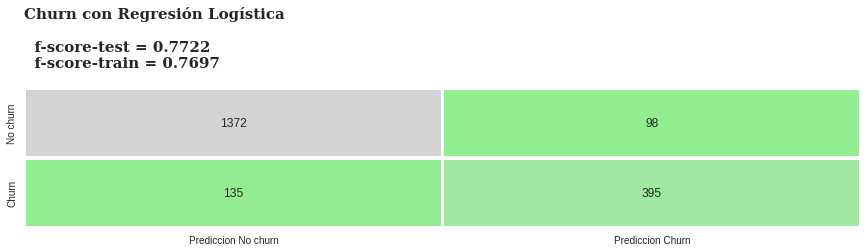

In [332]:
cm=confusion_matrix(y_test, pred_lg_v1)
text = '''Churn con Regresión Logística

  f-score-test = {} 
  f-score-train = {} '''.format(round(f1_score(y_test,pred_lg_v1),4),round(f1_score(y_train, clf_v1.predict(X_train_lr_v1)),4))

background_color = 'white' 
colormap = LinearSegmentedColormap.from_list("", ["lightgreen","lightgray"])


fig = plt.figure(figsize=(15,18)) 
fig.patch.set_facecolor(background_color) 
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

#grafico de la matriz de confusion 
sns.heatmap(cm, linewidths=2.5,yticklabels=['No churn','Churn'],
            xticklabels=['Prediccion No churn','Prediccion Churn'], 
            cmap=colormap, 
            cbar=None,
            annot=True,
            fmt='d',
            ax=ax0,
            annot_kws={"fontsize":12}
            )


ax0.text(0, -0.3, text,fontsize=15, fontweight='bold', fontfamily='serif')

###Opción 2: DataFrame sacando todas las correlacionadas

In [272]:
pred_lg_v2 = clf_v2.predict(X_test_lr_v2)

In [273]:
print(classification_report(y_test, pred_lg_v2))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1470
           1       0.80      0.73      0.77       530

    accuracy                           0.88      2000
   macro avg       0.86      0.83      0.84      2000
weighted avg       0.88      0.88      0.88      2000



In [280]:
results['logistic_op2']= {'algoritmo': 'Logística sacando todas las correlacionadas',
                       'f-score-train': f1_score(y_train, clf_v2.predict(X_train_lr_v2)),
                       'f-score-test': f1_score(y_test,pred_lg_v2),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_lg_v2),
                       'precision': precision_score(y_test, pred_lg_v2),
                       'recall': recall_score(y_test, pred_lg_v2),
                       'auc': roc_auc_score(y_test, pred_lg_v2),
                       'params': clf_v2.get_params()}

In [275]:
importance = clf_v2.coef_[0]
impo = pd.DataFrame(list(zip(X_test_lr_v2.columns, importance)), columns=['feature', 'importance'])
impo.sort_values('importance', ascending=False).head(10)

,feature,importance
5,monthlycharge,3.070392
23,contract_Month-to-month,2.773583
25,internetservice_DSL,1.984662
26,internetservice_None,1.225199
22,techie_Yes,0.742037
36,zip_zone_cat_2,0.113511
40,zip_zone_cat_6,0.087116
24,contract_One year,0.029723
1,yearly_equip_failure,0.003995
0,email,-0.011111


### Opción 3: PCA

In [276]:
pred_lg_pca = clf_pca.predict(X_test_pca)

In [277]:
print(classification_report(y_test, pred_lg_pca))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1470
           1       0.20      0.01      0.01       530

    accuracy                           0.73      2000
   macro avg       0.47      0.50      0.43      2000
weighted avg       0.59      0.73      0.62      2000



In [278]:
results['logistic_PCA']= {'algoritmo': 'Logística con PCA',
                       'f-score-train': f1_score(y_train, clf_pca.predict(X_train_pca)),
                       'f-score-test': f1_score(y_test,pred_lg_pca),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_lg_pca),
                       'precision': precision_score(y_test, pred_lg_pca),
                       'recall': recall_score(y_test, pred_lg_pca),
                       'auc': roc_auc_score(y_test, pred_lg_pca),
                       'params': clf_pca.get_params()}

In [281]:
pd.DataFrame(results).T

,algoritmo,f-score-train,f-score-test,balance_accurency,precision,recall,auc,params
tree_base,Decision Tree con X_train,1.0,0.720841,0.808381,0.73062,0.711321,0.808381,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
pred_tree_pca,Decision Tree con PCA,1.0,0.403377,0.593647,0.401119,0.40566,0.593647,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
tree_CV,Decision Tree con búsqueda de parámetros,0.778962,0.769086,0.843069,0.768362,0.769811,0.843069,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
rfc_base,Random Forest con X_train,1.0,0.794466,0.852034,0.834025,0.758491,0.852034,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
rfc_pca,Random forest con PCA,1.0,0.35782,0.587011,0.480892,0.284906,0.587011,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
rfc_CV,Random Forest con búsqueda de parámetros,0.873246,0.802721,0.860371,0.827655,0.779245,0.860371,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
logistic_op1,Logística sacando solo las relacionadas en EDA,0.769719,0.772239,0.839308,0.801217,0.745283,0.839308,"{'C': 1, 'class_weight': None, 'dual': False, ..."
logistic_op2,Logística sacando todas las correlacionadas,0.767351,0.766798,0.834065,0.804979,0.732075,0.834065,"{'C': 1, 'class_weight': None, 'dual': False, ..."
logistic_PCA,Logística con PCA,0.016446,0.014545,0.498331,0.2,0.007547,0.498331,"{'C': 1, 'class_weight': None, 'dual': False, ..."


## Predicción KNN


In [284]:
pred_knn = knn.predict(X_test)

In [285]:
results['knn']= {'algoritmo': 'Knn con X_test',
                       'f-score-train': f1_score(y_train, knn.predict(X_train)),
                       'f-score-test': f1_score(y_test,pred_knn),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_knn),
                       'precision': precision_score(y_test, pred_knn),
                       'recall': recall_score(y_test, pred_knn),
                       'auc': roc_auc_score(y_test, pred_knn),
                       'params': knn.get_params()}

In [286]:
pd.DataFrame(results).T

,algoritmo,f-score-train,f-score-test,balance_accurency,precision,recall,auc,params
tree_base,Decision Tree con X_train,1.0,0.720841,0.808381,0.73062,0.711321,0.808381,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
pred_tree_pca,Decision Tree con PCA,1.0,0.403377,0.593647,0.401119,0.40566,0.593647,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
tree_CV,Decision Tree con búsqueda de parámetros,0.778962,0.769086,0.843069,0.768362,0.769811,0.843069,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
rfc_base,Random Forest con X_train,1.0,0.794466,0.852034,0.834025,0.758491,0.852034,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
rfc_pca,Random forest con PCA,1.0,0.35782,0.587011,0.480892,0.284906,0.587011,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
rfc_CV,Random Forest con búsqueda de parámetros,0.873246,0.802721,0.860371,0.827655,0.779245,0.860371,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
logistic_op1,Logística sacando solo las relacionadas en EDA,0.769719,0.772239,0.839308,0.801217,0.745283,0.839308,"{'C': 1, 'class_weight': None, 'dual': False, ..."
logistic_op2,Logística sacando todas las correlacionadas,0.767351,0.766798,0.834065,0.804979,0.732075,0.834065,"{'C': 1, 'class_weight': None, 'dual': False, ..."
logistic_PCA,Logística con PCA,0.016446,0.014545,0.498331,0.2,0.007547,0.498331,"{'C': 1, 'class_weight': None, 'dual': False, ..."
knn,Knn con X_test,0.777835,0.567452,0.702721,0.655941,0.5,0.702721,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."


### KNN con busqueda de parametros

In [290]:
#prediccion
pred_knn_cv = CV_knn.predict(X_test)

In [292]:
results['knn_CV']= {'algoritmo': 'KNN con búsqueda de parámetros',
                       'f-score-train': f1_score(y_train, CV_knn.predict(X_train)),
                       'f-score-test': f1_score(y_test,pred_knn_cv),
                       'balance_accurency': balanced_accuracy_score(y_test, pred_knn_cv),
                       'precision': precision_score(y_test, pred_knn_cv),
                       'recall': recall_score(y_test, pred_knn_cv),
                        'auc': roc_auc_score(y_test, pred_knn_cv),
                       'params': CV_knn.best_estimator_.get_params()}

Text(0, -0.3, 'Churn con KNN\n\n  f-score-test = 0.5748 \n  f-score-train = 1.0 ')

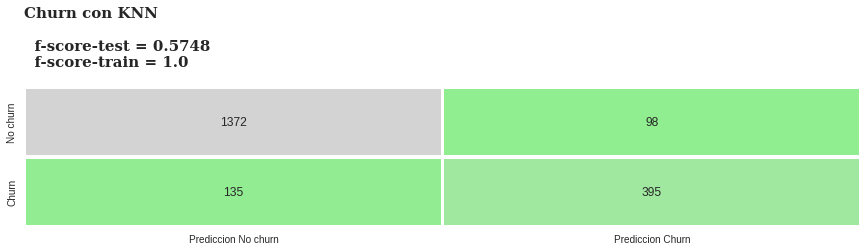

In [334]:
cm=confusion_matrix(y_test, pred_lg_v1)
text = '''Churn con KNN

  f-score-test = {} 
  f-score-train = {} '''.format(round(f1_score(y_test,pred_knn_cv),4),round(f1_score(y_train, CV_knn.predict(X_train)),4))

background_color = 'white' 
colormap = LinearSegmentedColormap.from_list("", ["lightgreen","lightgray"])


fig = plt.figure(figsize=(15,18)) 
fig.patch.set_facecolor(background_color) 
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

#grafico de la matriz de confusion 
sns.heatmap(cm, linewidths=2.5,yticklabels=['No churn','Churn'],
            xticklabels=['Prediccion No churn','Prediccion Churn'], 
            cmap=colormap, 
            cbar=None,
            annot=True,
            fmt='d',
            ax=ax0,
            annot_kws={"fontsize":12}
            )


ax0.text(0, -0.3, text,fontsize=15, fontweight='bold', fontfamily='serif')

# Tabla resumen métricas

In [335]:
pd.DataFrame(results).T.sort_values('f-score-test', ascending=False)

,algoritmo,f-score-train,f-score-test,balance_accurency,precision,recall,auc,params
rfc_CV,Random Forest con búsqueda de parámetros,0.873246,0.802721,0.860371,0.827655,0.779245,0.860371,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
rfc_base,Random Forest con X_train,1.0,0.794466,0.852034,0.834025,0.758491,0.852034,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
logistic_op1,Logística sacando solo las relacionadas en EDA,0.769719,0.772239,0.839308,0.801217,0.745283,0.839308,"{'C': 1, 'class_weight': None, 'dual': False, ..."
tree_CV,Decision Tree con búsqueda de parámetros,0.778962,0.769086,0.843069,0.768362,0.769811,0.843069,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
logistic_op2,Logística sacando todas las correlacionadas,0.767351,0.766798,0.834065,0.804979,0.732075,0.834065,"{'C': 1, 'class_weight': None, 'dual': False, ..."
tree_base,Decision Tree con X_train,1.0,0.720841,0.808381,0.73062,0.711321,0.808381,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
knn_CV,KNN con búsqueda de parámetros,1.0,0.574786,0.707175,0.662562,0.507547,0.707175,"{'algorithm': 'kd_tree', 'leaf_size': 5, 'metr..."
knn,Knn con X_test,0.777835,0.567452,0.702721,0.655941,0.5,0.702721,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
pred_tree_pca,Decision Tree con PCA,1.0,0.403377,0.593647,0.401119,0.40566,0.593647,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
rfc_pca,Random forest con PCA,1.0,0.35782,0.587011,0.480892,0.284906,0.587011,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
